In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import os
import sys

import torch
from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import training     as tr

## Species
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'
idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')
molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
epochs = 40

kwargs = {'num_workers': 1, 'pin_memory': True} 

In [2]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

train, data_loader, test_loader = ds.get_dataset(dir, batch_size, kwargs, plot = False)

Dataset:
------------------------------
total # of samples: 2997
# training samples: 2097
# testing samples:  900
            ratio:  0.3


In [3]:
## Set up training hyperparams
lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1e0]                   ## learning rate

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'straight'

## Build models
model = ae.build(input_dim, hidden_dim, latent_dim,output_dim, nb_hidden, type, DEVICE)
ae.name(model, 'Encoder','Decoder','Model')
ae.overview(model)


Overview Model:
___________________________________

Encoder:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |       3010
  output |    10 |          /
-----------------------------------
         |       |     324310

Decoder:
       # | nodes | parameters
-----------------------------------
   input |    10 |       3300
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     324768


Model:         Model
learning rate: 0.0001
	Epoch 40 complete! 	Average loss train:  0.09166612724463145 	Average loss test:  0.08867303282022476
 	DONE!



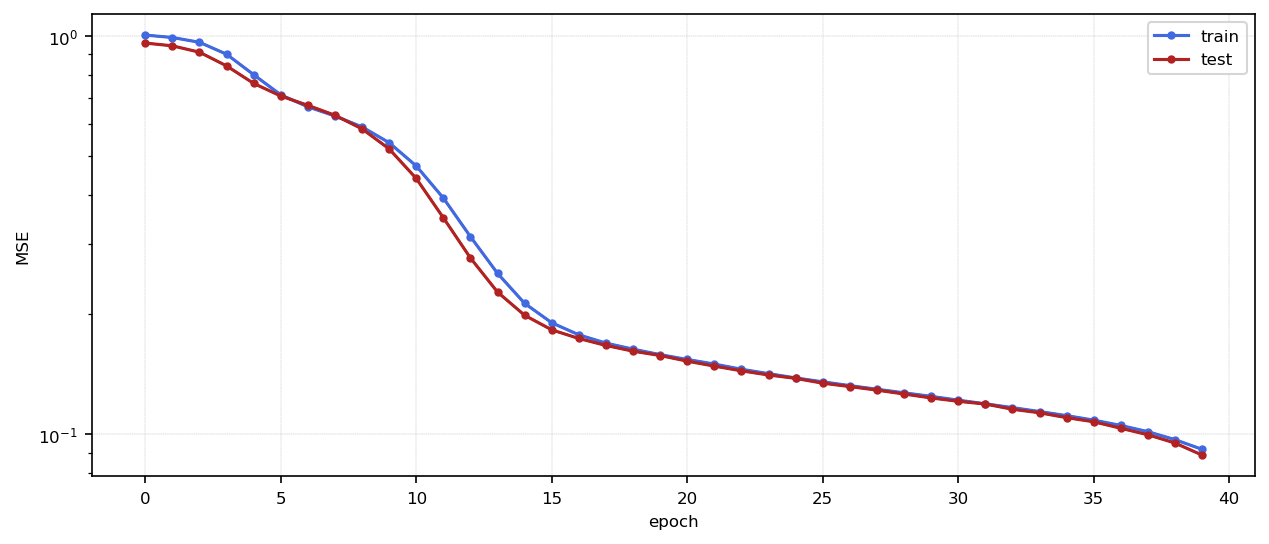

Model:         Model
learning rate: 0.0003
	Epoch 40 complete! 	Average loss train:  0.0167664767109922 	Average loss test:  0.01869585923850536323
 	DONE!



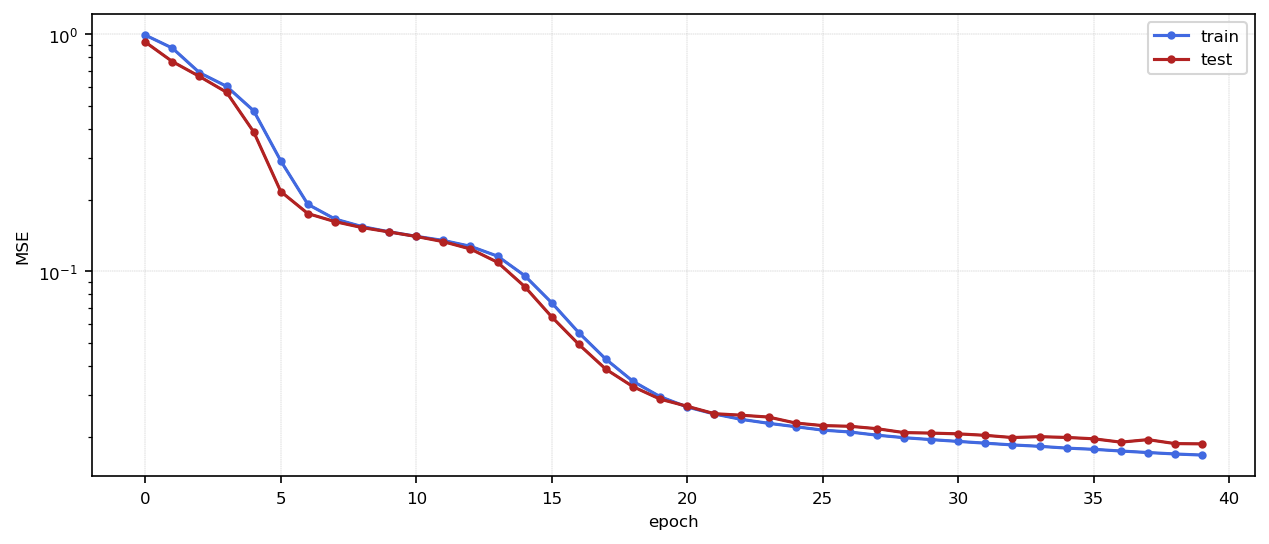

Model:         Model
learning rate: 0.001
	Epoch 40 complete! 	Average loss train:  0.009642602077552251 	Average loss test:  0.011527924798429012
 	DONE!



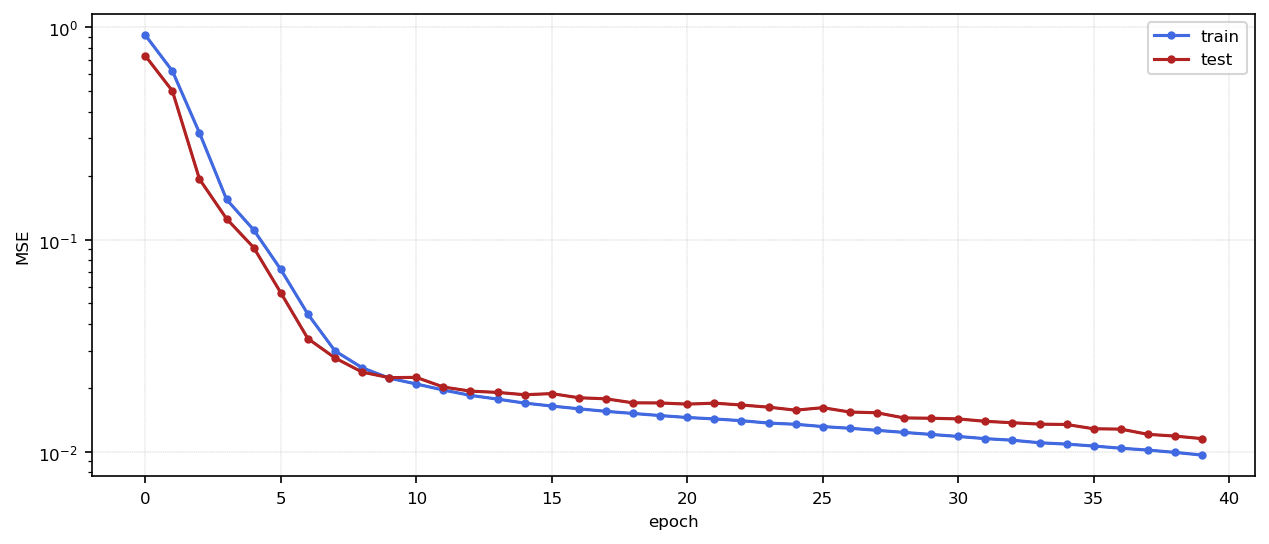

Model:         Model
learning rate: 0.003
	Epoch 40 complete! 	Average loss train:  0.00427507672325841 	Average loss test:  0.00644578319042921148
 	DONE!



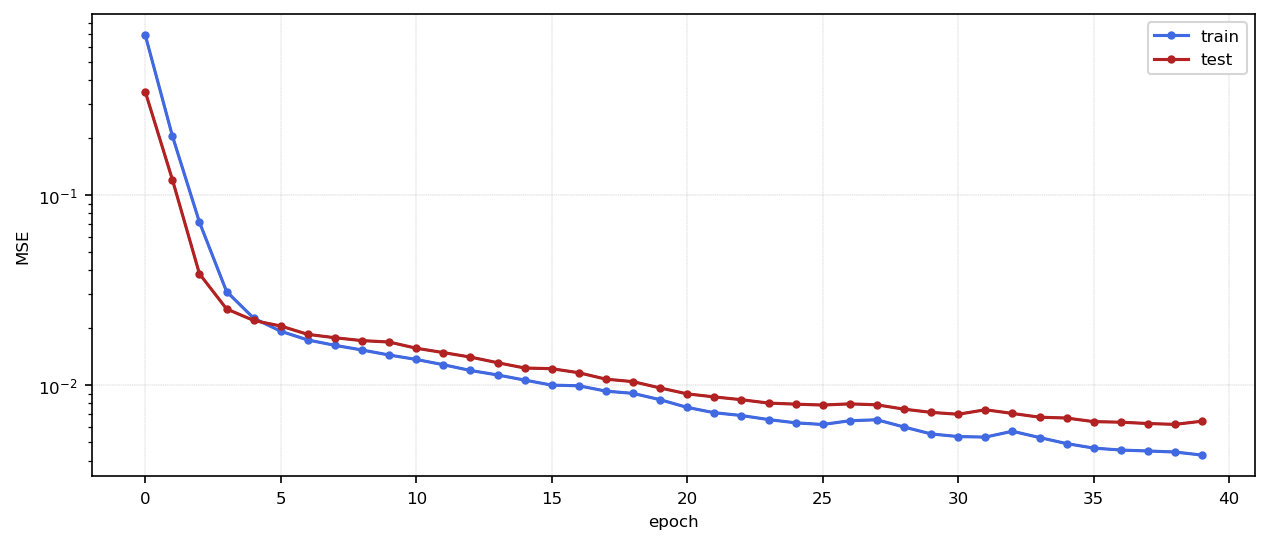

Model:         Model
learning rate: 0.01
	Epoch 40 complete! 	Average loss train:  0.0037230639274986018 	Average loss test:  0.0052949776872992516
 	DONE!



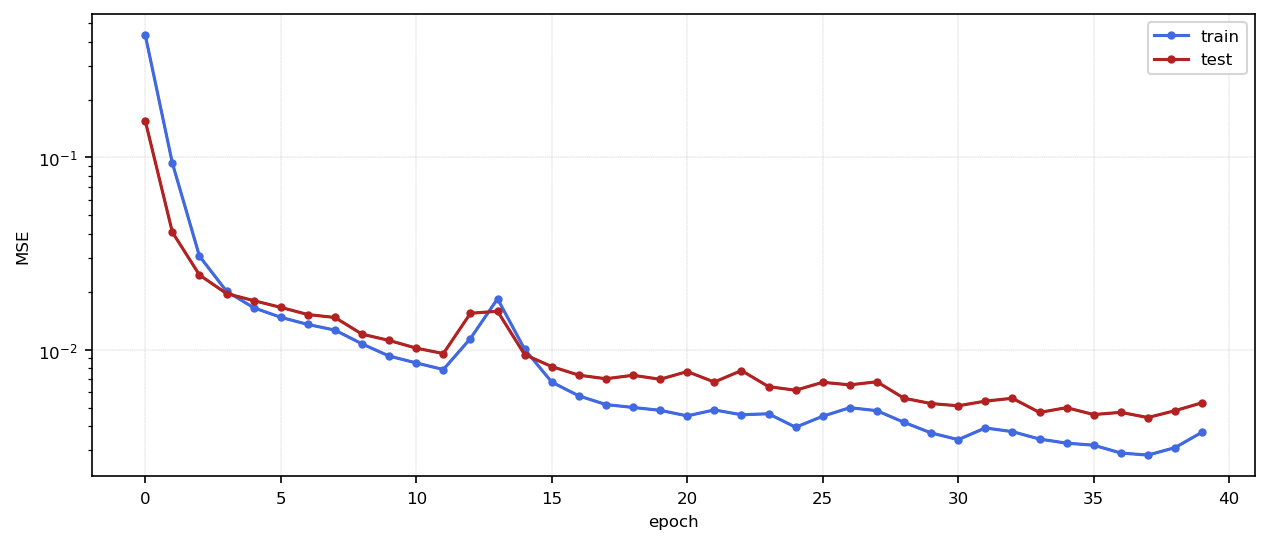

Model:         Model
learning rate: 0.03
	Epoch 40 complete! 	Average loss train:  0.005203503250543561 	Average loss test:  0.0066736475564539435
 	DONE!



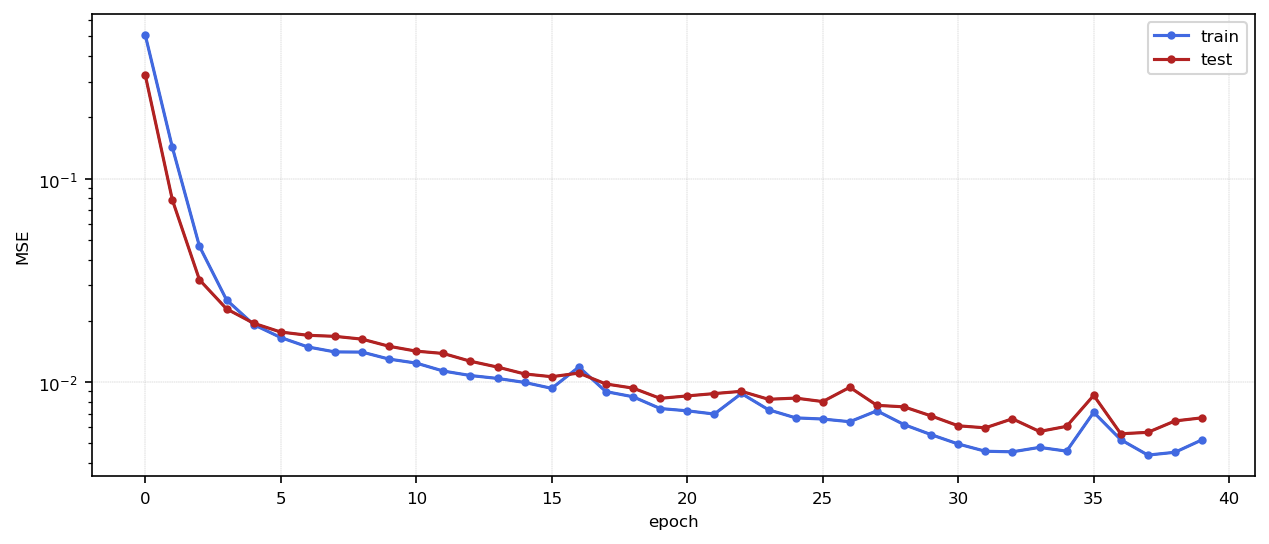

Model:         Model
learning rate: 0.1
	Epoch 40 complete! 	Average loss train:  0.03901449324829238 	Average loss test:  0.0352235473692417146
 	DONE!



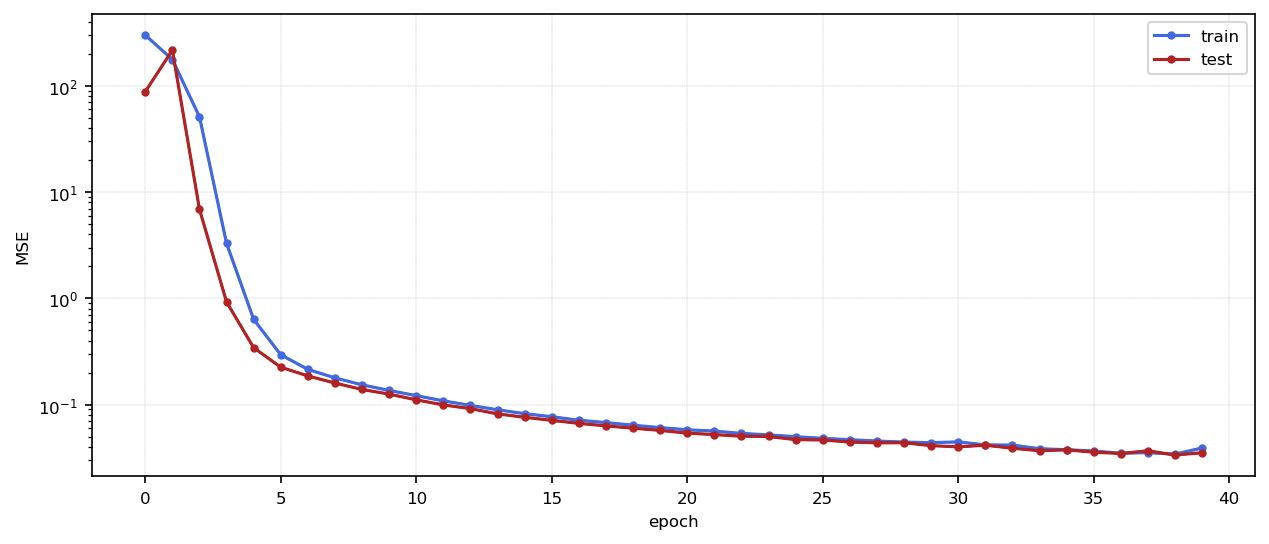

Model:         Model
learning rate: 0.3
	Epoch 40 complete! 	Average loss train:  10.319250015985398 	Average loss test:  8.0901880264282236
 	DONE!



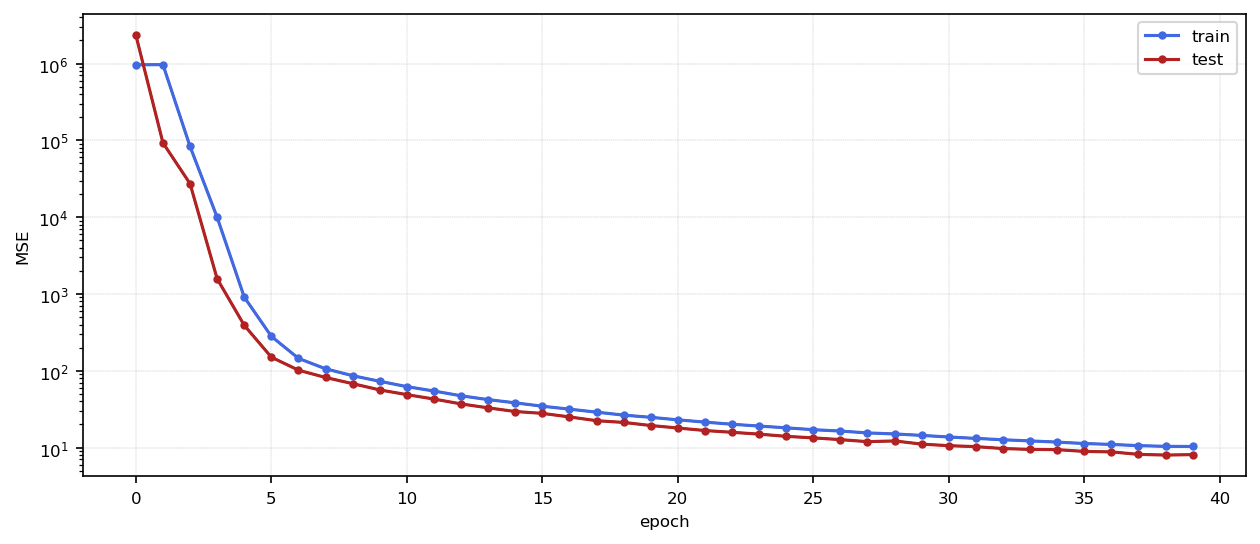

Model:         Model
learning rate: 1.0
	Epoch 40 complete! 	Average loss train:  363660.09821428574 	Average loss test:  332749.43755
 	DONE!



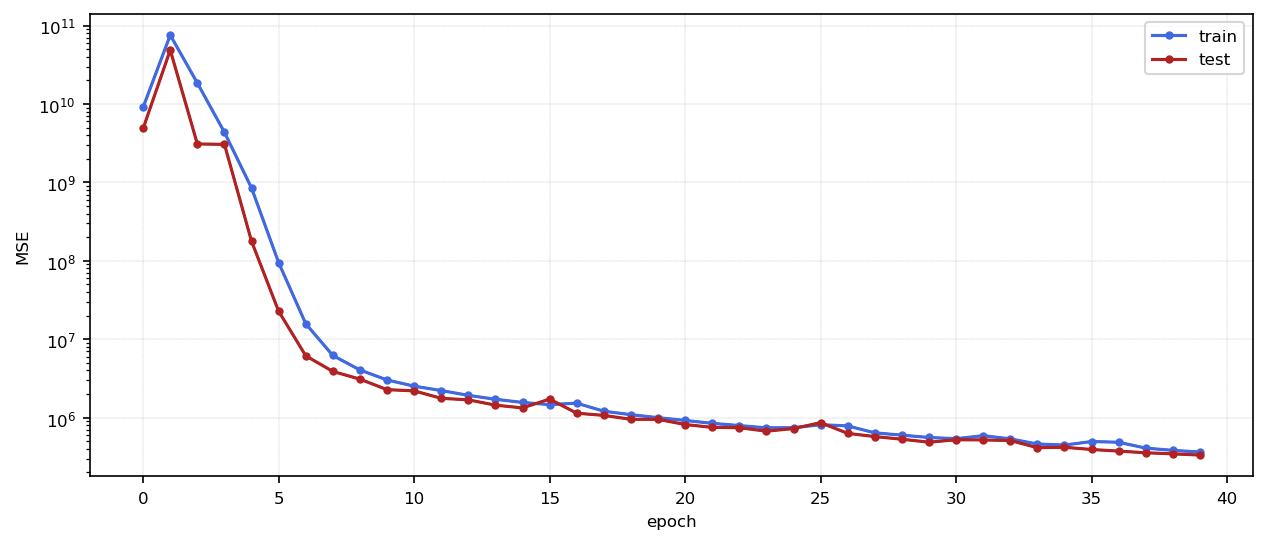

In [4]:
## Training model
for lr in lrs:
    model = ae.build(input_dim, hidden_dim, latent_dim,output_dim, nb_hidden, type, DEVICE)
    ae.name(model, 'Encoder','Decoder','Model')
    
    loss_train_all, loss_test_all = tr.Train(model, lr, data_loader, test_loader, epochs, DEVICE, plot = True)

    torch.save(model,'/lhome/silkem/MACE/MACE/ae-models/learning-rate/ae-model-lr'+str(lr)+'.pl')

In [4]:
## Testing model
path = '/lhome/silkem/MACE/MACE/ae-models/learning-rate/'
locs = os.listdir(path) 

for loc in locs:
    model = torch.load(path+loc)
    x_test, x_test_hat, loss = tr.Test(model, test_loader, DEVICE)

loss Model:  0.01202224288135767


In [5]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'
rad, real, pred = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')

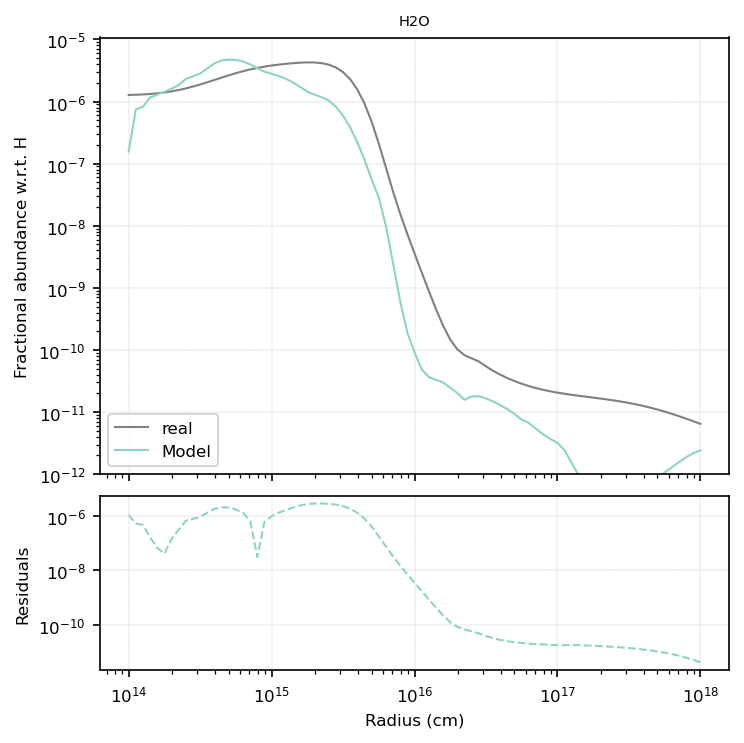

In [7]:
pl.plot_fracs_profile(rad, real, [pred], [model], molecs, 'H2O')